In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score


In [5]:
# file paths for the datasets
train_path = './../data/layer 10/layer_10_train.csv'
valid_path = './../data/layer 10/layer_10_valid.csv'
test_path = './../data/layer 10/layer_10_test.csv'

# Load the train dataset
train_data = pd.read_csv(train_path)

# Load the valid dataset
valid_data = pd.read_csv(valid_path)

# Load the test dataset
test_data = pd.read_csv(test_path)

In [6]:
test_data = test_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_4'])

In [7]:
train_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_1,label_2,label_3,label_4
0,-0.027083,0.072947,-0.093659,0.053418,-0.085516,-0.102610,-0.021217,0.016162,-0.184269,0.110335,...,-0.183643,0.091299,-0.037097,0.042607,-0.034361,-0.013748,45,NaN,1,6
1,0.070195,0.228641,-0.132860,-0.077761,-0.054993,-0.210365,0.127747,-0.132385,-0.161366,0.172764,...,-0.123668,0.029626,-0.027345,0.055223,-0.179725,0.136841,45,NaN,1,6
2,0.164312,0.052808,-0.058510,0.104724,-0.025886,-0.101427,-0.047177,0.091298,-0.094569,0.088062,...,0.075410,0.070125,0.043022,0.012972,-0.028920,0.096725,45,NaN,1,6
3,0.029730,0.113737,0.061113,-0.099329,-0.111600,-0.245942,0.086520,0.071996,0.028319,0.207910,...,-0.062511,-0.226912,-0.046011,0.011282,-0.095167,0.039979,45,NaN,1,6
4,0.031364,0.142409,-0.160743,-0.076594,-0.062412,-0.264732,0.079197,0.026060,-0.217023,0.084656,...,-0.193882,0.107297,-0.042355,0.046763,-0.192469,0.006463,45,NaN,1,6


In [8]:
# datasets for each label in train dataset
train_data_label1 = train_data.drop(columns=['label_2', 'label_3', 'label_4'])
train_data_label2 = train_data.drop(columns=['label_1', 'label_3', 'label_4'])
train_data_label3 = train_data.drop(columns=['label_1', 'label_2', 'label_4'])
train_data_label4 = train_data.drop(columns=['label_1', 'label_2', 'label_3'])

# datasets for each label in train dataset
valid_data_label1 = valid_data.drop(columns=['label_2', 'label_3', 'label_4'])
valid_data_label2 = valid_data.drop(columns=['label_1', 'label_3', 'label_4'])
valid_data_label3 = valid_data.drop(columns=['label_1', 'label_2', 'label_4'])
valid_data_label4 = valid_data.drop(columns=['label_1', 'label_2', 'label_3'])

In [9]:
train_features = train_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_4'])
valid_features = valid_data.drop(columns=['label_1', 'label_2', 'label_3', 'label_4'])

In [10]:
train_features_array = train_features.to_numpy()

valid_features_array = valid_features.to_numpy()

test_features_array = test_data.to_numpy()

In [11]:
train_features_array.shape

(28520, 768)

In [12]:
train_features.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
count,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,...,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000,28520.000000
mean,0.035587,0.078413,-0.040854,0.079167,-0.033728,-0.129528,-0.004608,-0.016071,-0.080182,0.047877,...,-0.049483,0.033645,0.053965,-0.143643,-0.121131,0.024537,-0.023062,0.053033,-0.060110,-0.031766
std,0.066663,0.051860,0.056119,0.061433,0.055724,0.078193,0.055673,0.067243,0.070111,0.061358,...,0.074011,0.051502,0.067165,0.092567,0.082048,0.065089,0.063021,0.081957,0.061217,0.074294
min,-0.278307,-0.108783,-0.374459,-0.230660,-0.382474,-0.464895,-0.218843,-0.385482,-0.386470,-0.396842,...,-0.432509,-0.307550,-0.291500,-0.749655,-0.400943,-0.261302,-0.271254,-0.383916,-0.350115,-0.296535
25%,-0.003948,0.044925,-0.074197,0.040072,-0.069260,-0.182223,-0.041694,-0.057925,-0.123943,0.008245,...,-0.100288,0.000011,0.011932,-0.201563,-0.172992,-0.015233,-0.067517,-0.006157,-0.099727,-0.081620
50%,0.032880,0.076560,-0.039102,0.079309,-0.031002,-0.124762,-0.006371,-0.015115,-0.077953,0.046913,...,-0.050168,0.031891,0.047450,-0.139523,-0.129561,0.023859,-0.027330,0.050707,-0.056456,-0.031862
75%,0.068754,0.109380,-0.005096,0.118440,0.004372,-0.072187,0.030630,0.025157,-0.036984,0.086407,...,0.002732,0.065629,0.087472,-0.081206,-0.082763,0.062431,0.016195,0.110795,-0.019083,0.017753
max,0.537892,0.365866,0.329586,0.397721,0.214701,0.215949,0.461929,0.373033,0.433161,0.333654,...,0.239659,0.257337,0.588633,0.430334,0.345534,0.487504,0.596317,0.348570,0.334053,0.395296


Isolation Forest

In [ ]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(train_features_array)

Minimum Covariance Determinant

In [ ]:
# identify outliers in the training dataset
ee = EllipticEnvelope(contamination=0.01)
yhat = ee.fit_predict(train_features_array)

Local Outlier Factor

In [ ]:
# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(train_features_array)

One-Class SVM

In [ ]:
# identify outliers in the training dataset
ee = OneClassSVM(nu=0.01)
yhat = ee.fit_predict(train_features_array)

Remove outliers

In [ ]:
# select all rows that are not outliers
mask = yhat != -1

train_features_array, train_labels_array = train_features_array[mask, :], train_labels_array[mask, :]

In [ ]:
train_features_array.shape

# Label 1

In [13]:
# check for null values in train dataset
print(f"train_data_label1 shape before : {train_data_label1.shape}")
train_null_counts = train_data_label1.isnull().sum()
print(f"train null counts before : \n{train_null_counts}")

# drop rows with null values in the target labels for train dataset
train_data_label1 = train_data_label1.dropna(subset=train_data_label1.columns[-1:], how='any')
print(f"train_data_label1 shape after : {train_data_label1.shape}")

train_data_label1 shape before : (28520, 769)
train null counts before : 
feature_1      0
feature_2      0
feature_3      0
feature_4      0
feature_5      0
              ..
feature_765    0
feature_766    0
feature_767    0
feature_768    0
label_1        0
Length: 769, dtype: int64
train_data_label1 shape after : (28520, 769)


In [14]:
# fill null values with mean in train dataset
train_data_label1 = train_data_label1.fillna(train_data_label1.mean())

# fill null values with mean in valid dataset
valid_data_label1 = valid_data_label1.fillna(valid_data_label1.mean())

# fill null values with mean in test dataset
test_data = test_data.fillna(test_data.mean())

In [15]:
#seperate features and target labels

train_features_label1 = train_data_label1.iloc[:, :-1]
train_label1 = train_data_label1.iloc[:, -1]

valid_features_label1 = valid_data_label1.iloc[:, :-1]
valid_label1 = valid_data_label1.iloc[:, -1]

test_features_label1 = test_data

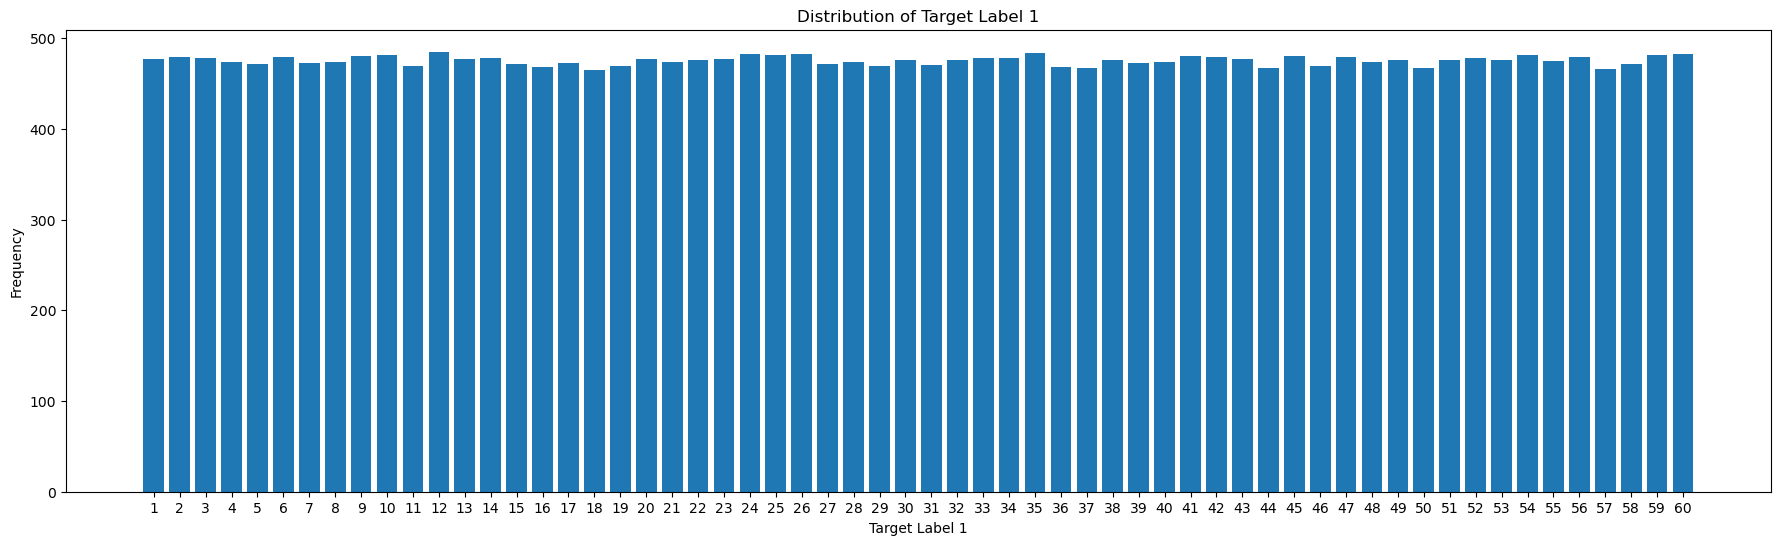

In [16]:
# plot the distribution of train_label1
labels, counts = np.unique(train_label1, return_counts=True)

plt.figure(figsize=(22, 6))
plt.xticks(labels)
plt.bar(labels, counts)
plt.xlabel('Target Label 1')
plt.ylabel('Frequency')
plt.title('Distribution of Target Label 1')
plt.show()

In [17]:
# standardize the features
scaler = RobustScaler()
standardized_train_features_label1 = scaler.fit_transform(train_features_label1)
standardized_valid_features_label1 = scaler.transform(valid_features_label1)
standardized_test_features_label1 = scaler.transform(test_features_label1)

joblib.dump(scaler, './../saved_components/layer10/label_1/scaler.pkl')

['./../saved_components/layer10/label_1/scaler.pkl']

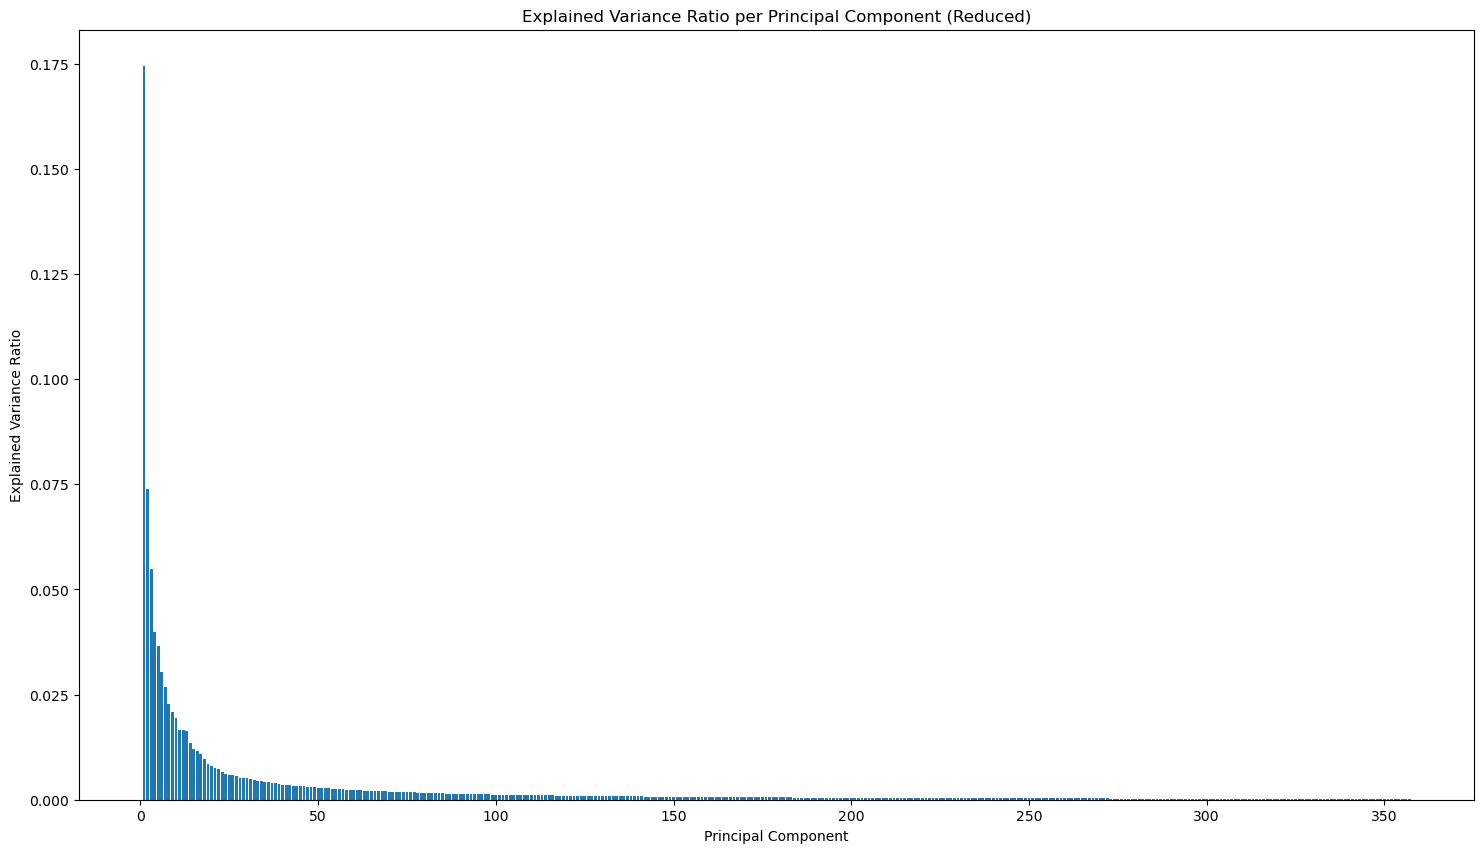

Reduced Train feature matrix shape: (28520, 357)
Reduced valid feature matrix shape: (750, 357)
Reduced test feature matrix shape: (750, 357)


['./../saved_components/layer10/label_1/pca.pkl']

In [19]:
# threshold for variance
variance_threshold = 0.97

# apply PCA with the determined number of components
pca = PCA(n_components=variance_threshold, svd_solver='full')

pca_train_features_label1 = pca.fit_transform(standardized_train_features_label1)
pca_valid_features_label1 = pca.transform(standardized_valid_features_label1)
pca_test_features_label1 = pca.transform(standardized_test_features_label1)

# explained variance ratio after dimensionality reduction
explained_variance_ratio_reduced = pca.explained_variance_ratio_

# plot explained variance ratio
plt.figure(figsize=(18, 10))
plt.bar(range(1, pca_train_features_label1.shape[1] + 1), explained_variance_ratio_reduced)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component (Reduced)')
plt.show()

# get the reduced train feature matrix
print("Reduced Train feature matrix shape: {}".format(pca_train_features_label1.shape))
# get the reduced valid feature matrix
print("Reduced valid feature matrix shape: {}".format(pca_valid_features_label1.shape))
# get the reduced test feature matrix
print("Reduced test feature matrix shape: {}".format(pca_test_features_label1.shape))

joblib.dump(pca, './../saved_components/layer10/label_1/pca.pkl')

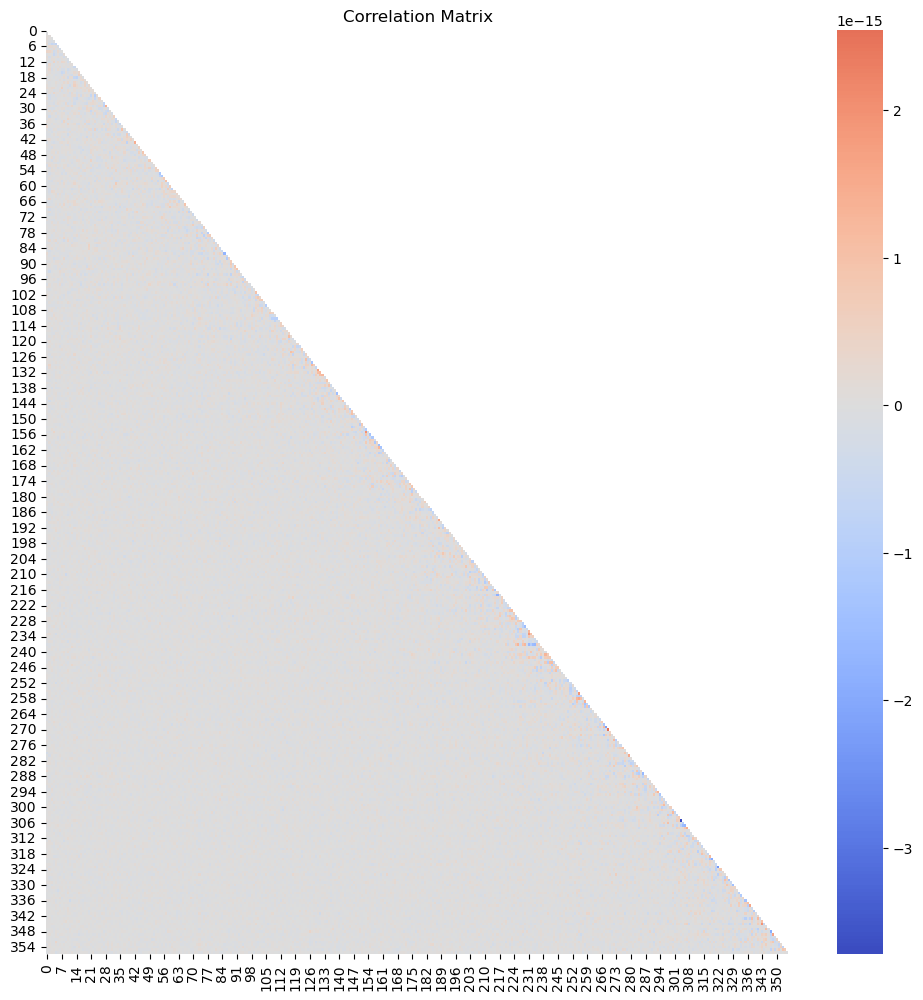

In [20]:
#calculate the correlation matrix
correlation_matrix = pd.DataFrame(pca_train_features_label1).corr()

mask = np.triu(np.ones_like(correlation_matrix))

# create a heatmap of the correlation matrix using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, mask=mask)
plt.title("Correlation Matrix")
plt.show()

In [21]:
# threshold for correlation
correlation_threshold = 0.9

highly_correlated = set()

# get highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)

print(highly_correlated)

set()


In [22]:
# remove highly correlated features
pca_train_features_label1 = pd.DataFrame(pca_train_features_label1).drop(columns=highly_correlated)
pca_valid_features_label1 = pd.DataFrame(pca_valid_features_label1).drop(columns=highly_correlated)
pca_test_features_label1 = pd.DataFrame(pca_test_features_label1).drop(columns=highly_correlated)

# get the filtered train feature count
print("Filtered train features: {}".format(pca_train_features_label1.shape))

# get the filtered valid feature count
print("Filtered valid features: {}".format(pca_valid_features_label1.shape))

# get the filtered test feature count
print("Filtered test features: {}".format(pca_test_features_label1.shape))

Filtered train features: (28520, 357)
Filtered valid features: (750, 357)
Filtered test features: (750, 357)


In [23]:
# calculate the correlation matrix between features and train_label1
correlation_with_target = pca_train_features_label1.corrwith(train_label1)

# correlation threshold
correlation_threshold = 0.005

# select features that meet the correlation threshold
highly_correlated_features = correlation_with_target[correlation_with_target.abs() > correlation_threshold]

print(highly_correlated_features)

0     -0.058638
1      0.108520
2      0.007337
3      0.108840
4      0.031059
         ...   
351    0.019048
352    0.035644
353    0.011993
354    0.017138
355    0.017250
Length: 304, dtype: float64


In [24]:
# drop the features with low correlated in train data
pca_train_features_label1 = pca_train_features_label1[highly_correlated_features.index]

# drop the features with low correlated in valid data
pca_valid_features_label1 = pca_valid_features_label1[highly_correlated_features.index]

# drop the features with low correlated in test data
pca_test_features_label1 = pca_test_features_label1[highly_correlated_features.index]


# get the filtered train feature count
print("Filtered train features: {}".format(pca_train_features_label1.shape))

# get the filtered valid feature count
print("Filtered valid features: {}".format(pca_valid_features_label1.shape))

# get the filtered test feature count
print("Filtered test features: {}".format(pca_test_features_label1.shape))

Filtered train features: (28520, 304)
Filtered valid features: (750, 304)
Filtered test features: (750, 304)


In [ ]:
# parameters for hyperparameter tuning of label 1 with SVM

svm_grid_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','linear']
}


# search across all different combinations, and use all available cores
rs = HalvingGridSearchCV(
    estimator = SVC(),
    param_grid = svm_grid_params,
    factor = 2,
    cv = 3, verbose=2, n_jobs = -1
)
rs_result = rs.fit(pca_train_features_label1, train_label1)

print(f"best score for SVM : {rs_result.best_score_}")
print(f"best hyper parameters for SVM : {rs_result.best_params_}")

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 891
max_resources_: 28520
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 891
Fitting 3 folds for each of 50 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 25
n_resources: 1782
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 2
n_candidates: 13
n_resources: 3564
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 3
n_candidates: 7
n_resources: 7128
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 4
n_candidates: 4
n_resources: 14256
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 5
n_candidates: 2
n_resources: 28512
Fitting 3 folds for each of 2 candidates, totalling 6 fits
best score for SVM : 0.9473186364858731
best hyper parameters for SVM : {'C': 100, 'gamma': 1, 'kernel': 'linear'}


In [25]:
# define the classification model
model = SVC(C=100, gamma=1, kernel='linear')

# get number of features used in PCA
num_features = pca_train_features_label1.shape[1]
print(f"Number of features: {num_features}\n")


# train the model on the training data
model.fit(pca_train_features_label1, train_label1)

# predict on the train data
y_pred_train_label1 = model.predict(pca_train_features_label1)

# calculate metrics for classification evaluation
accuracy = accuracy_score(train_label1, y_pred_train_label1)
precision = precision_score(train_label1, y_pred_train_label1, average='macro', zero_division=1)
recall = recall_score(train_label1, y_pred_train_label1, average='macro')

print(f"Metrics for SVM on train data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

# predict on the validation data
y_pred_valid_label1 = model.predict(pca_valid_features_label1)

# calculate metrics for classification evaluation on validation data
accuracy = accuracy_score(valid_label1, y_pred_valid_label1)
precision = precision_score(valid_label1, y_pred_valid_label1, average='macro', zero_division=1)
recall = recall_score(valid_label1, y_pred_valid_label1, average='macro')

print(f"Metrics for SVM on validation data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

# predict on the test data
y_pred_test_label1 = model.predict(pca_test_features_label1)

joblib.dump(model, './../saved_components/layer10/label_1/model.pkl')

Number of features: 304



Metrics for SVM on train data:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


Metrics for SVM on validation data:
Accuracy: 0.95
Precision: 0.96
Recall: 0.96




['./../saved_components/layer10/label_1/model.pkl']

# Label 2

In [26]:
# check for null values in train dataset
print(f"train_data_label2 shape before : {train_data_label2.shape}")
train_null_counts = train_data_label2.isnull().sum()
print(f"train null counts before : \n{train_null_counts}")

# drop rows with null values in the target labels for train dataset
train_data_label2 = train_data_label2.dropna(subset=train_data_label2.columns[-1:], how='any')
print(f"train_data_label2 shape after : {train_data_label2.shape}")

train_data_label2 shape before : (28520, 769)
train null counts before : 
feature_1        0
feature_2        0
feature_3        0
feature_4        0
feature_5        0
              ... 
feature_765      0
feature_766      0
feature_767      0
feature_768      0
label_2        480
Length: 769, dtype: int64
train_data_label2 shape after : (28040, 769)


In [27]:
# fill null values with mean in train dataset
train_data_label2 = train_data_label2.fillna(train_data_label2.mean())

# fill null values with mean in valid dataset
valid_data_label2 = valid_data_label2.fillna(valid_data_label2.mean())

# fill null values with mean in test dataset
test_data = test_data.fillna(test_data.mean())

In [28]:
#seperate features and target labels
train_features_label2 = train_data_label2.iloc[:, :-1]
train_label2 = train_data_label2.iloc[:, -1].astype('int64')

valid_features_label2 = valid_data_label2.iloc[:, :-1]
valid_label2 = valid_data_label2.iloc[:, -1].astype('int64')

test_features_label2 = test_data

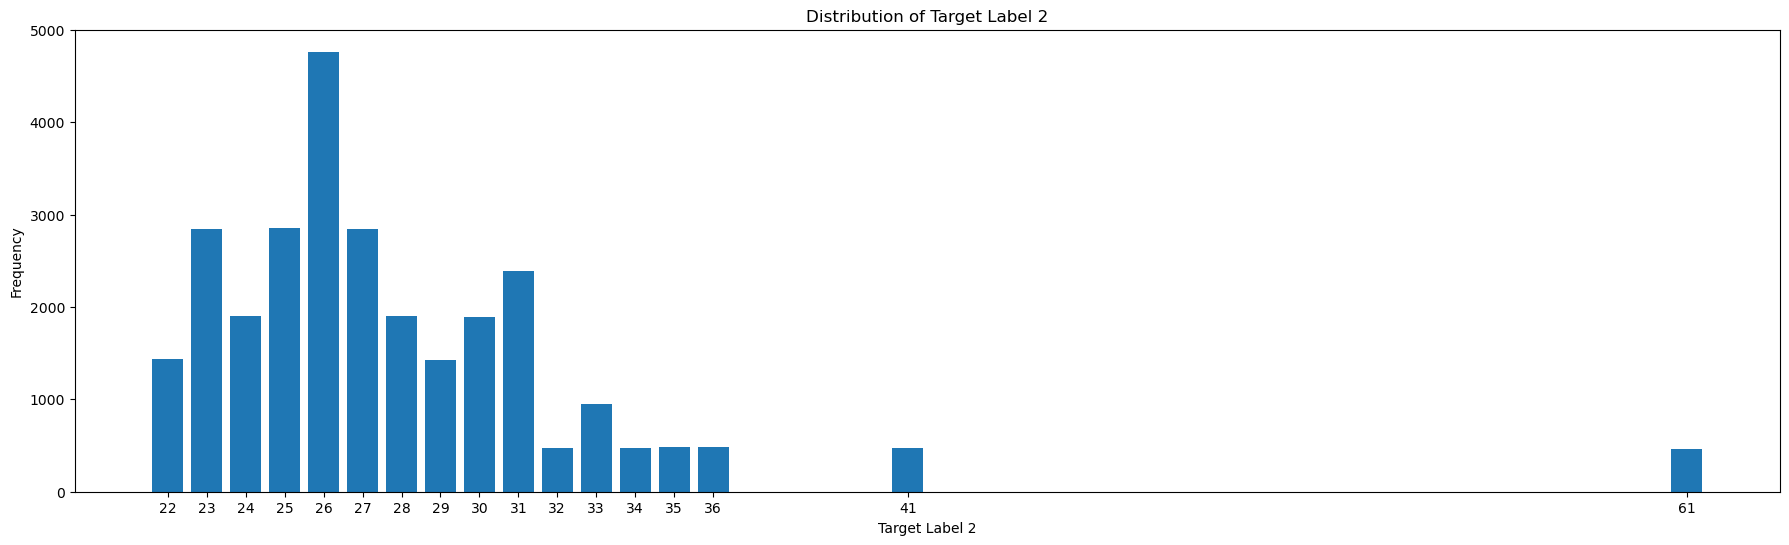

In [29]:
# plot the distribution of train_label2
labels, counts = np.unique(train_label2, return_counts=True)

plt.figure(figsize=(22, 6))
plt.xticks(labels)
plt.bar(labels, counts)
plt.xlabel('Target Label 2')
plt.ylabel('Frequency')
plt.title('Distribution of Target Label 2')
plt.show()

In [30]:
# create an instance of the RandomOverSampler
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# create an instance of the RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# create a pipeline that first applies over-sampling and then under-sampling
sampling_pipeline = Pipeline([
    ('over_sampling', over_sampler),
    ('under_sampling', under_sampler)
])

train_features_label2, train_label2 = sampling_pipeline.fit_resample(train_features_label2, train_label2)

In [31]:
# standardize the features
scaler = RobustScaler()
standardized_train_features_label2 = scaler.fit_transform(train_features_label2)
standardized_valid_features_label2 = scaler.transform(valid_features_label2)
standardized_test_features_label2 = scaler.transform(test_features_label2)

joblib.dump(scaler, './../saved_components/layer10/label_2/scaler.pkl')

['./../saved_components/layer10/label_2/scaler.pkl']

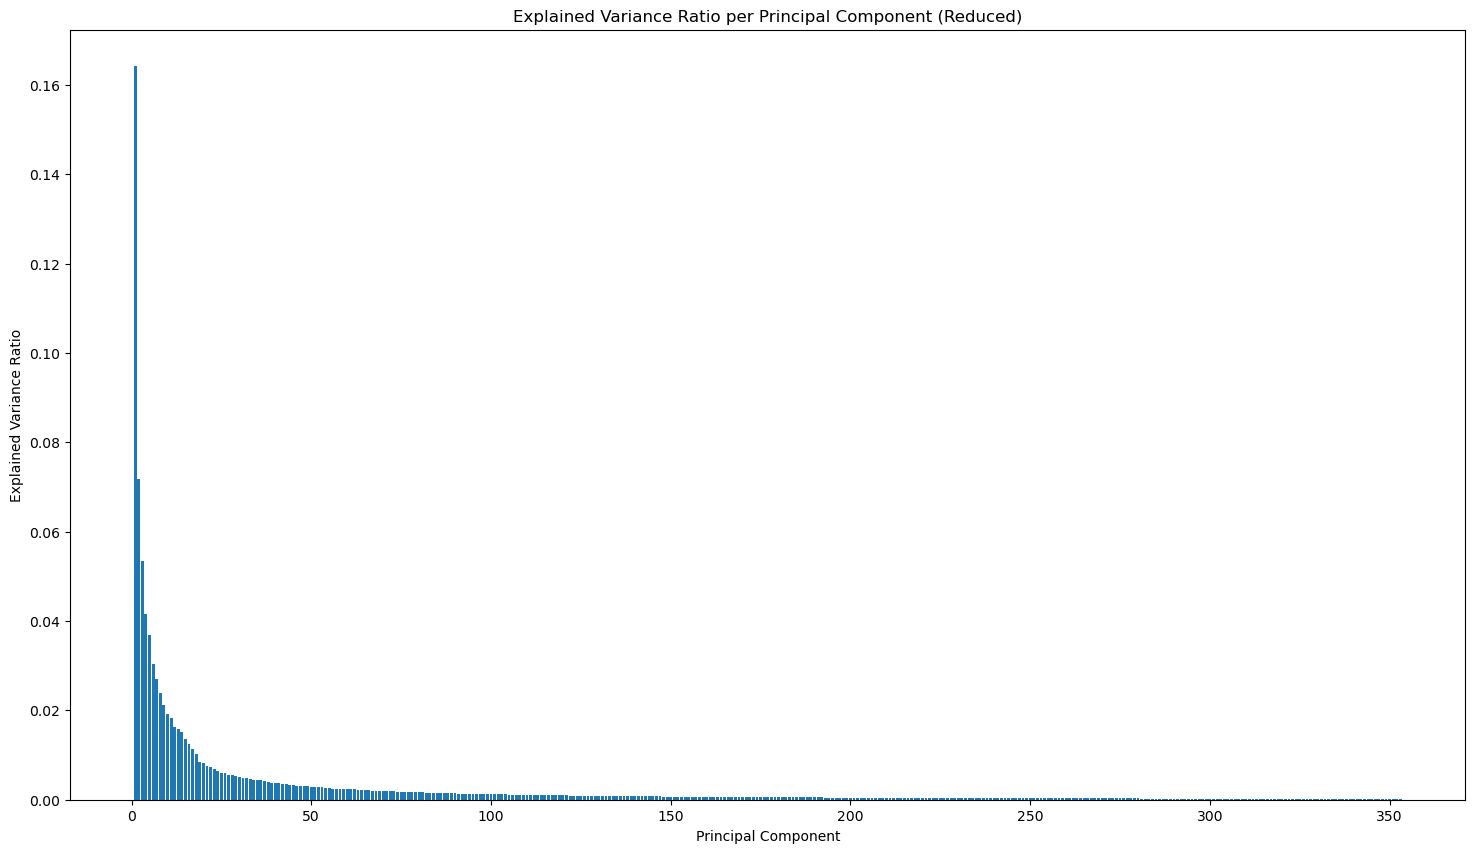

Reduced Train feature matrix shape: (80954, 353)
Reduced valid feature matrix shape: (750, 353)
Reduced test feature matrix shape: (750, 353)


['./../saved_components/layer10/label_2/pca.pkl']

In [32]:
# threshold for variance
variance_threshold = 0.97

# apply PCA with the determined number of components
pca = PCA(n_components=variance_threshold, svd_solver='full')

pca_train_features_label2 = pca.fit_transform(standardized_train_features_label2)
pca_valid_features_label2 = pca.transform(standardized_valid_features_label2)
pca_test_features_label2 = pca.transform(standardized_test_features_label2)

# explained variance ratio after dimensionality reduction
explained_variance_ratio_reduced = pca.explained_variance_ratio_

# plot explained variance ratio
plt.figure(figsize=(18, 10))
plt.bar(range(1, pca_train_features_label2.shape[1] + 1), explained_variance_ratio_reduced)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component (Reduced)')
plt.show()

# get the reduced train feature matrix
print("Reduced Train feature matrix shape: {}".format(pca_train_features_label2.shape))
# get the reduced valid feature matrix
print("Reduced valid feature matrix shape: {}".format(pca_valid_features_label2.shape))
# get the reduced test feature matrix
print("Reduced test feature matrix shape: {}".format(pca_test_features_label2.shape))

joblib.dump(pca, './../saved_components/layer10/label_2/pca.pkl')

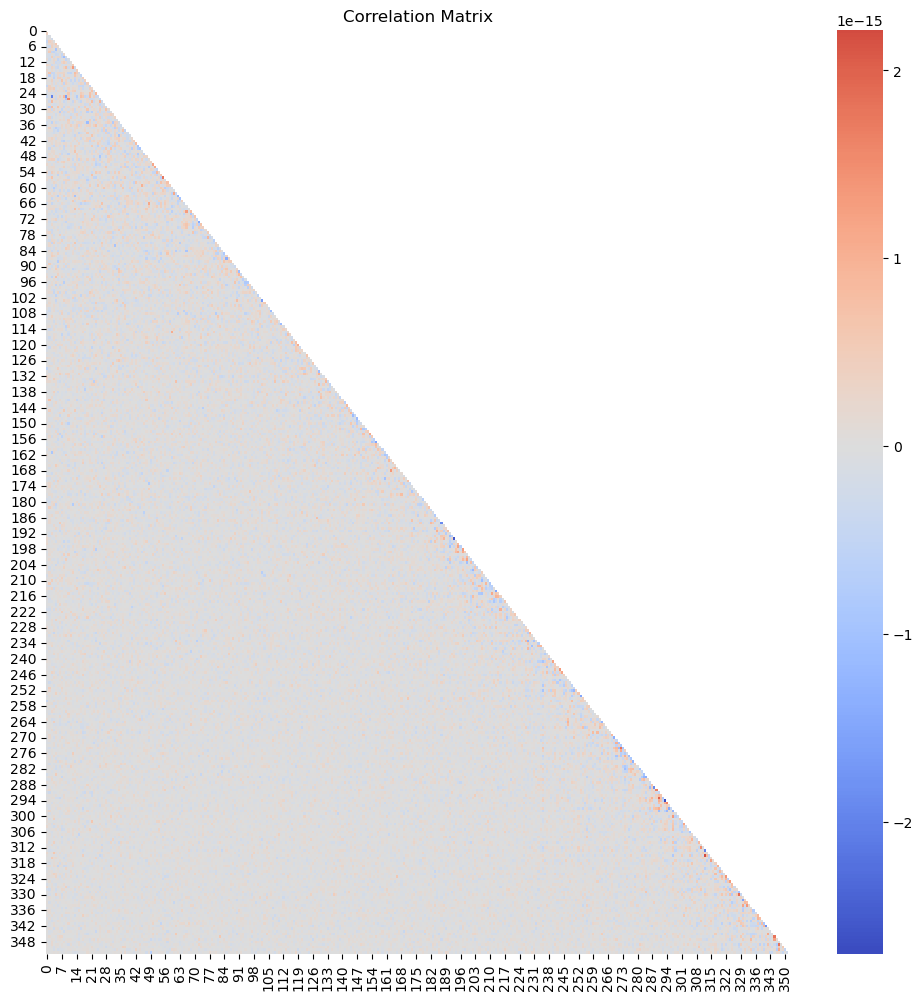

In [33]:
#calculate the correlation matrix
correlation_matrix = pd.DataFrame(pca_train_features_label2).corr()

mask = np.triu(np.ones_like(correlation_matrix))

# create a heatmap of the correlation matrix using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, mask=mask)
plt.title("Correlation Matrix")
plt.show()

In [34]:
# threshold for correlation
correlation_threshold = 0.9

highly_correlated = set()

# get highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)

print(highly_correlated)

set()


In [35]:
# remove highly correlated features
pca_train_features_label2 = pd.DataFrame(pca_train_features_label2).drop(columns=highly_correlated)
pca_valid_features_label2 = pd.DataFrame(pca_valid_features_label2).drop(columns=highly_correlated)
pca_test_features_label2 = pd.DataFrame(pca_test_features_label2).drop(columns=highly_correlated)

# get the filtered train feature count
print("Filtered train features: {}".format(pca_train_features_label2.shape))

# get the filtered valid feature count
print("Filtered valid features: {}".format(pca_valid_features_label2.shape))

# get the filtered test feature count
print("Filtered test features: {}".format(pca_test_features_label2.shape))

Filtered train features: (80954, 353)
Filtered valid features: (750, 353)
Filtered test features: (750, 353)


In [36]:
# calculate the correlation matrix between features and train_label1
correlation_with_target = pca_train_features_label2.corrwith(train_label2)

# set the correlation threshold
correlation_threshold = 0.005

# select features that meet the correlation threshold
highly_correlated_features = correlation_with_target[correlation_with_target.abs() > correlation_threshold]

print(highly_correlated_features)

0     -0.047143
2      0.067647
3     -0.006918
4     -0.126908
5      0.034933
         ...   
345   -0.026682
346   -0.016890
348    0.011234
349   -0.006703
351    0.006699
Length: 271, dtype: float64


In [37]:
# drop the features with low correlated in train data
pca_train_features_label2 = pca_train_features_label2[highly_correlated_features.index]

# drop the features with low correlated in valid data
pca_valid_features_label2 = pca_valid_features_label2[highly_correlated_features.index]

# drop the features with low correlated in test data
pca_test_features_label2 = pca_test_features_label2[highly_correlated_features.index]


# get the filtered train feature count
print("Filtered train features: {}".format(pca_train_features_label2.shape))

# get the filtered valid feature count
print("Filtered valid features: {}".format(pca_valid_features_label2.shape))

# get the filtered test feature count
print("Filtered test features: {}".format(pca_test_features_label2.shape))

Filtered train features: (80954, 271)
Filtered valid features: (750, 271)
Filtered test features: (750, 271)


In [96]:
# parameters for hyperparameter tuning of label 2 with SVM

svm_grid_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','linear']
}


# search across all different combinations, and use all available cores
rs = HalvingGridSearchCV(
    estimator = SVC(),
    param_grid = svm_grid_params,
    factor = 2,
    cv = 3, verbose=2, n_jobs = -1
)
rs_result = rs.fit(pca_train_features_label2, train_label2)

print(f"best score for SVM : {rs_result.best_score_}")
print(f"best hyper parameters for SVM : {rs_result.best_params_}")

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 2529
max_resources_: 80954
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 2529
Fitting 3 folds for each of 50 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 25
n_resources: 5058
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 2
n_candidates: 13
n_resources: 10116
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 3
n_candidates: 7
n_resources: 20232
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 4
n_candidates: 4
n_resources: 40464
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 5
n_candidates: 2
n_resources: 80928
Fitting 3 folds for each of 2 candidates, totalling 6 fits
best score for SVM : 0.9841462148438631
best hyper parameters for SVM : {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [38]:
# define the classification model
model = SVC(C=100, gamma=0.001, kernel='rbf')

# get number of features used in PCA
num_features = pca_train_features_label2.shape[1]
print(f"Number of features: {num_features}\n")


# train the model on the training data
model.fit(pca_train_features_label2, train_label2)

# predict on the train data
y_pred_train_label2 = model.predict(pca_train_features_label2)

# calculate metrics for classification evaluation
accuracy = accuracy_score(train_label2, y_pred_train_label2)
precision = precision_score(train_label2, y_pred_train_label2, average='macro', zero_division=1)
recall = recall_score(train_label2, y_pred_train_label2, average='macro')

print(f"Metrics for SVM on train data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

# predict on the validation data
y_pred_valid_label2 = model.predict(pca_valid_features_label2)

# calculate metrics for classification evaluation on validation data
accuracy = accuracy_score(valid_label2, y_pred_valid_label2)
precision = precision_score(valid_label2, y_pred_valid_label2, average='macro', zero_division=1)
recall = recall_score(valid_label2, y_pred_valid_label2, average='macro')

print(f"Metrics for SVM on validation data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

# predict on the test data
y_pred_test_label2 = model.predict(pca_test_features_label2)

joblib.dump(model, './../saved_components/layer10/label_2/model.pkl')

Number of features: 271

Metrics for SVM on train data:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


Metrics for SVM on validation data:
Accuracy: 0.91
Precision: 0.94
Recall: 0.92




['./../saved_components/layer10/label_2/model.pkl']

# Label 3

In [39]:
# check for null values in train dataset
print(f"train_data_label3 shape before : {train_data_label3.shape}")
train_null_counts = train_data_label3.isnull().sum()
print(f"train null counts before : \n{train_null_counts}")

# drop rows with null values in the target labels for train dataset
train_data_label3 = train_data_label3.dropna(subset=train_data_label3.columns[-1:], how='any')
print(f"train_data_label3 shape after : {train_data_label3.shape}")

train_data_label3 shape before : (28520, 769)
train null counts before : 
feature_1      0
feature_2      0
feature_3      0
feature_4      0
feature_5      0
              ..
feature_765    0
feature_766    0
feature_767    0
feature_768    0
label_3        0
Length: 769, dtype: int64
train_data_label3 shape after : (28520, 769)


In [40]:
# fill null values with mean in train dataset
train_data_label3 = train_data_label3.fillna(train_data_label3.mean())

# fill null values with mean in valid dataset
valid_data_label3 = valid_data_label3.fillna(valid_data_label3.mean())

# fill null values with mean in test dataset
test_data = test_data.fillna(test_data.mean())

In [41]:
train_features_label3 = train_data_label3.iloc[:, :-1]
train_label3 = train_data_label3.iloc[:, -1]

valid_features_label3 = valid_data_label3.iloc[:, :-1]
valid_label3 = valid_data_label3.iloc[:, -1]

test_features_label3 = test_data

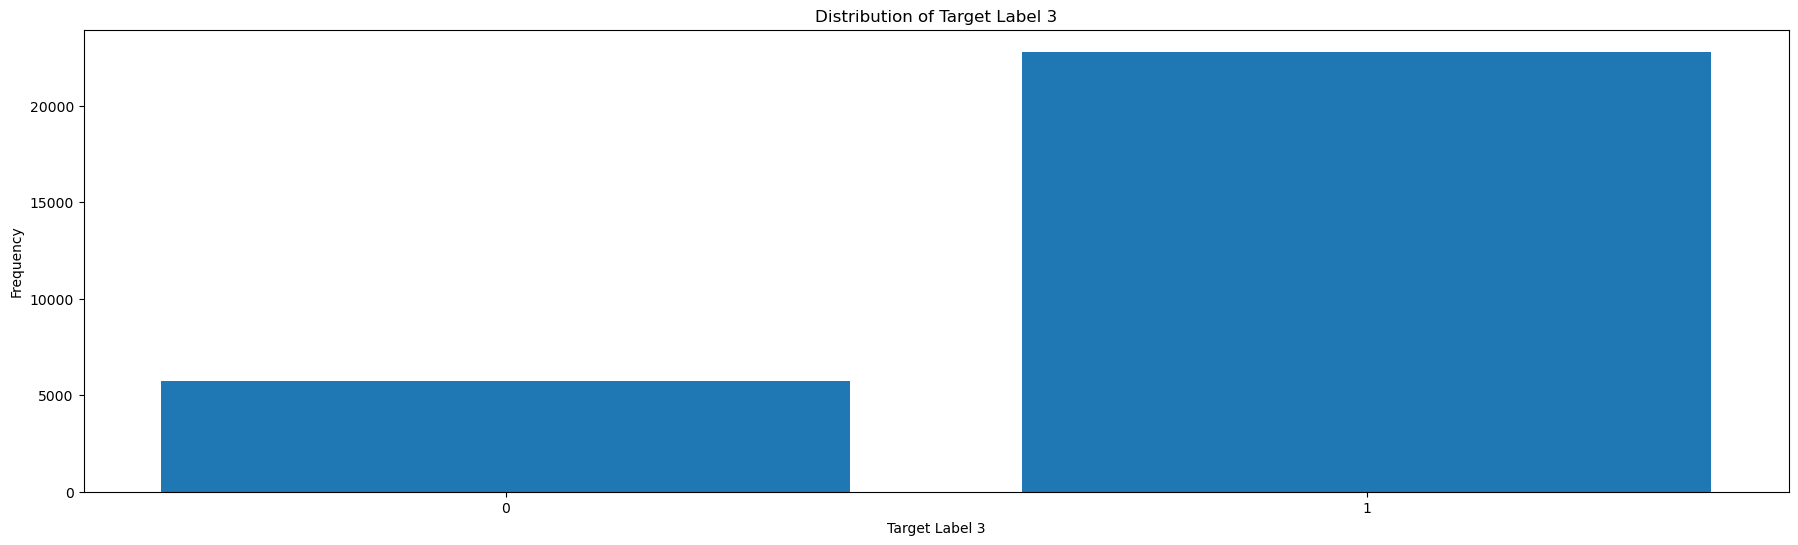

In [42]:
# plot the distribution of train_label3
labels, counts = np.unique(train_label3, return_counts=True)

plt.figure(figsize=(22, 6))
plt.xticks(labels)
plt.bar(labels, counts)
plt.xlabel('Target Label 3')
plt.ylabel('Frequency')
plt.title('Distribution of Target Label 3')
plt.show()

In [43]:
# create an instance of the RandomOverSampler
over_sampler = RandomOverSampler(sampling_strategy=0.5, random_state=42)

# create an instance of the RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# create a pipeline that first applies over-sampling and then under-sampling
sampling_pipeline = Pipeline([
    # ('over_sampling', over_sampler),
    ('under_sampling', under_sampler)
])

train_features_label3, train_label3 = sampling_pipeline.fit_resample(train_features_label3, train_label3)

In [44]:
# standardize the features
scaler = RobustScaler()
standardized_train_features_label3 = scaler.fit_transform(train_features_label3)
standardized_valid_features_label3 = scaler.transform(valid_features_label3)
standardized_test_features_label3 = scaler.transform(test_features_label3)

joblib.dump(scaler, './../saved_components/layer10/label_3/scaler.pkl')

['./../saved_components/layer10/label_3/scaler.pkl']

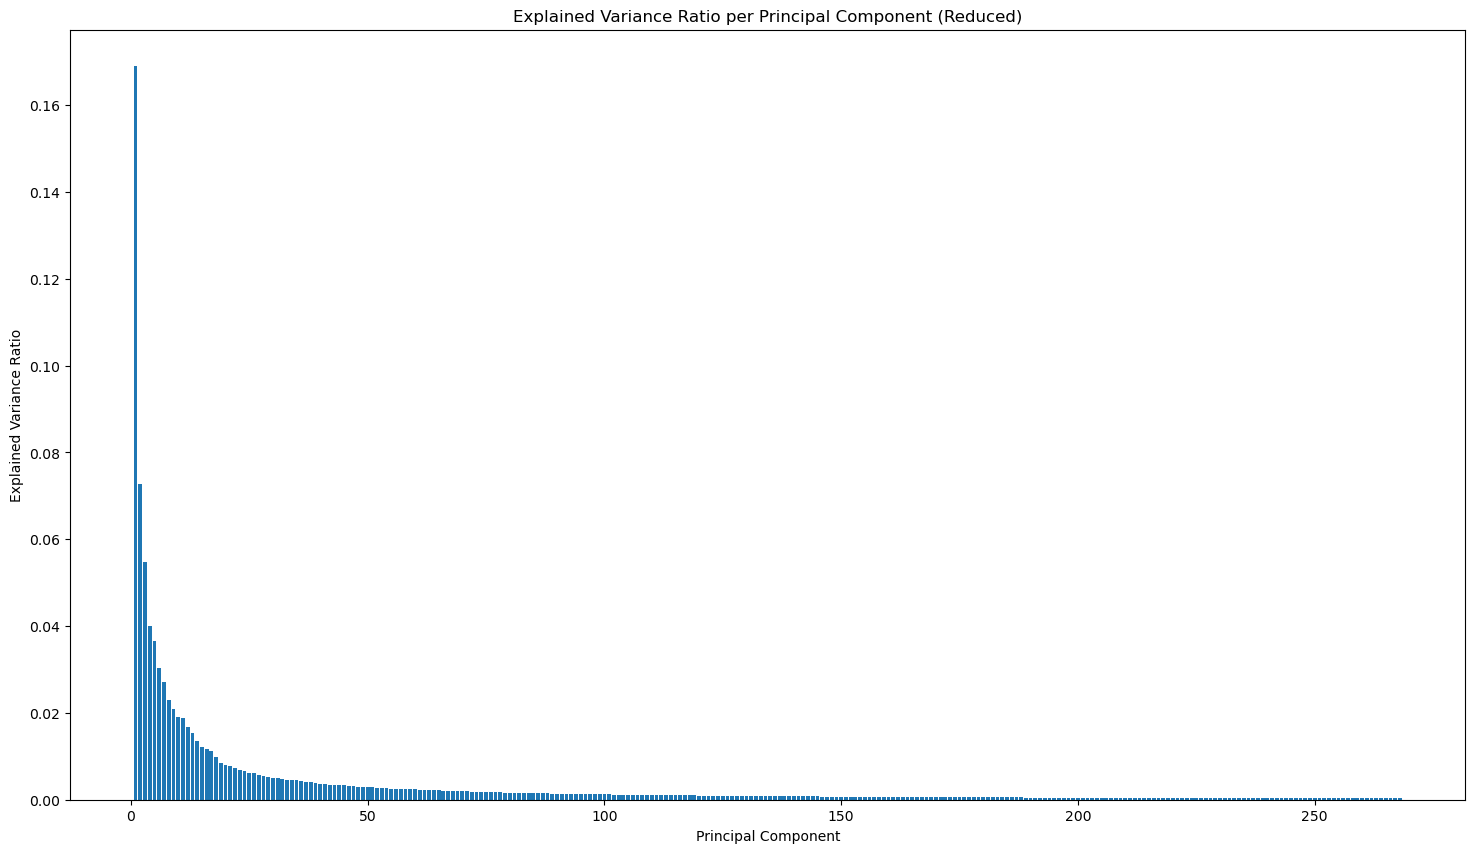

Reduced Train feature matrix shape: (17172, 268)
Reduced valid feature matrix shape: (750, 268)
Reduced test feature matrix shape: (750, 268)


['./../saved_components/layer10/label_3/pca.pkl']

In [45]:
# threshold for variance
variance_threshold = 0.95

# apply PCA with the determined number of components
pca = PCA(n_components=variance_threshold, svd_solver='full')

pca_train_features_label3 = pca.fit_transform(standardized_train_features_label3)
pca_valid_features_label3 = pca.transform(standardized_valid_features_label3)
pca_test_features_label3 = pca.transform(standardized_test_features_label3)

# explained variance ratio after dimensionality reduction
explained_variance_ratio_reduced = pca.explained_variance_ratio_

# plot explained variance ratio
plt.figure(figsize=(18, 10))
plt.bar(range(1, pca_train_features_label3.shape[1] + 1), explained_variance_ratio_reduced)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component (Reduced)')
plt.show()

# get the reduced train feature matrix
print("Reduced Train feature matrix shape: {}".format(pca_train_features_label3.shape))
# get the reduced valid feature matrix
print("Reduced valid feature matrix shape: {}".format(pca_valid_features_label3.shape))
# get the reduced test feature matrix
print("Reduced test feature matrix shape: {}".format(pca_test_features_label3.shape))

joblib.dump(pca, './../saved_components/layer10/label_3/pca.pkl')

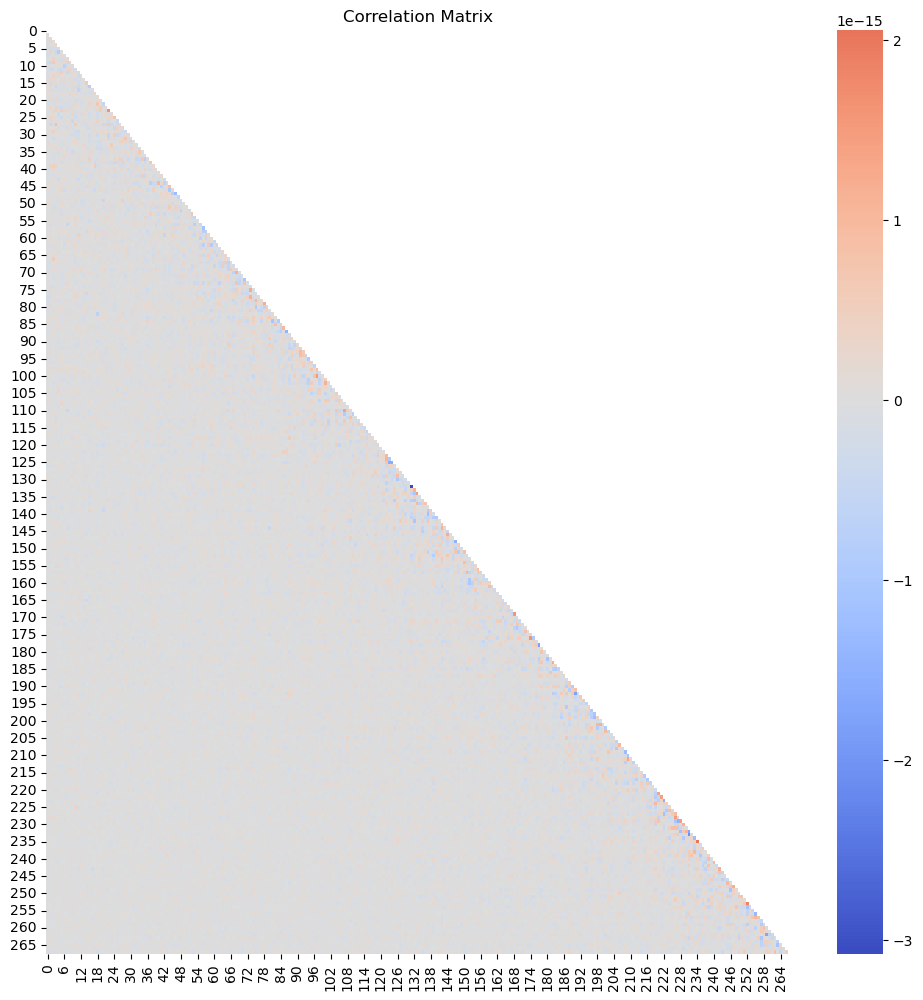

In [46]:
#calculate the correlation matrix
correlation_matrix = pd.DataFrame(pca_train_features_label3).corr()

mask = np.triu(np.ones_like(correlation_matrix))

# create a heatmap of the correlation matrix using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, mask=mask)
plt.title("Correlation Matrix")
plt.show()

In [47]:
# threshold for correlation
correlation_threshold = 0.9

highly_correlated = set()

# get highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)

print(highly_correlated)

set()


In [48]:
# remove highly correlated features
pca_train_features_label3 = pd.DataFrame(pca_train_features_label3).drop(columns=highly_correlated)
pca_valid_features_label3 = pd.DataFrame(pca_valid_features_label3).drop(columns=highly_correlated)
pca_test_features_label3 = pd.DataFrame(pca_test_features_label3).drop(columns=highly_correlated)

# get the filtered train feature count
print("Filtered train features: {}".format(pca_train_features_label3.shape))

# get the filtered valid feature count
print("Filtered valid features: {}".format(pca_valid_features_label3.shape))

# get the filtered test feature count
print("Filtered test features: {}".format(pca_test_features_label3.shape))

Filtered train features: (17172, 268)
Filtered valid features: (750, 268)
Filtered test features: (750, 268)


In [49]:
# calculate the correlation matrix between features and train_label3
correlation_with_target = pca_train_features_label3.corrwith(train_label3)

# set the correlation threshold
correlation_threshold = 0.005

# select features that meet the correlation threshold
highly_correlated_features = correlation_with_target[correlation_with_target.abs() > correlation_threshold]

print(highly_correlated_features)

0      0.013956
1     -0.014703
2     -0.019442
3     -0.008230
4     -0.064900
         ...   
262   -0.005289
263    0.008793
264   -0.005353
265   -0.008053
267   -0.025881
Length: 223, dtype: float64


In [50]:
# drop the features with low correlated in train data
pca_train_features_label3 = pca_train_features_label3[highly_correlated_features.index]

# drop the features with low correlated in valid data
pca_valid_features_label3 = pca_valid_features_label3[highly_correlated_features.index]

# drop the features with low correlated in test data
pca_test_features_label3 = pca_test_features_label3[highly_correlated_features.index]


# get the filtered train feature count
print("Filtered train features: {}".format(pca_train_features_label3.shape))

# get the filtered valid feature count
print("Filtered valid features: {}".format(pca_valid_features_label3.shape))

# get the filtered test feature count
print("Filtered test features: {}".format(pca_test_features_label3.shape))

Filtered train features: (17172, 223)
Filtered valid features: (750, 223)
Filtered test features: (750, 223)


In [121]:
# parameters for hyperparameter tuning of label 3 with SVM
svm_grid_params = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf','linear']
}

# search across all different combinations, and use all available cores
rs = HalvingGridSearchCV(
    estimator = SVC(),
    param_grid = svm_grid_params,
    factor = 2,
    cv = 3, verbose=2, n_jobs = -1
)
rs_result = rs.fit(pca_train_features_label3, train_label3)

print(f"best score for SVM : {rs_result.best_score_}")
print(f"best hyper parameters for SVM : {rs_result.best_params_}")

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1073
max_resources_: 17172
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 1073
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 9
n_resources: 2146
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 5
n_resources: 4292
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 3
n_resources: 8584
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 4
n_candidates: 2
n_resources: 17168
Fitting 3 folds for each of 2 candidates, totalling 6 fits
best score for SVM : 0.968717231737155
best hyper parameters for SVM : {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}


In [51]:
# define the classification model
model = SVC(C=10, gamma=0.001, kernel='rbf')

# get number of features used in PCA
num_features = pca_train_features_label3.shape[1]
print(f"Number of features: {num_features}\n")

# train the model on the training data
model.fit(pca_train_features_label3, train_label3)

# predict on the train data
y_pred_train_label3 = model.predict(pca_train_features_label3)

# calculate metrics for classification evaluation
accuracy = accuracy_score(train_label3, y_pred_train_label3)
precision = precision_score(train_label3, y_pred_train_label3, average='macro', zero_division=1)
recall = recall_score(train_label3, y_pred_train_label3, average='macro')

print(f"Metrics for SVM on train data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

# predict on the validation data
y_pred_valid_label3 = model.predict(pca_valid_features_label3)

# calculate metrics for classification evaluation on validation data
accuracy = accuracy_score(valid_label3, y_pred_valid_label3)
precision = precision_score(valid_label3, y_pred_valid_label3, average='macro', zero_division=1)
recall = recall_score(valid_label3, y_pred_valid_label3, average='macro')

print(f"Metrics for SVM on validation data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

# predict on the test data
y_pred_test_label3 = model.predict(pca_test_features_label3)

joblib.dump(model, './../saved_components/layer10/label_3/model.pkl')

Number of features: 223

Metrics for SVM on train data:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


Metrics for SVM on validation data:
Accuracy: 1.00
Precision: 0.99
Recall: 1.00




['./../saved_components/layer10/label_3/model.pkl']

# Label 4

In [52]:
# check for null values in train dataset
print(f"train_data_label4 shape before : {train_data_label4.shape}")
train_null_counts = train_data_label4.isnull().sum()
print(f"train null counts before : \n{train_null_counts}")

# drop rows with null values in the target labels for train dataset
train_data_label4 = train_data_label4.dropna(subset=train_data_label4.columns[-1:], how='any')
print(f"train_data_label4 shape after : {train_data_label4.shape}")

train_data_label4 shape before : (28520, 769)
train null counts before : 
feature_1      0
feature_2      0
feature_3      0
feature_4      0
feature_5      0
              ..
feature_765    0
feature_766    0
feature_767    0
feature_768    0
label_4        0
Length: 769, dtype: int64
train_data_label4 shape after : (28520, 769)


In [53]:
# fill null values with mean in train dataset
train_data_label4 = train_data_label4.fillna(train_data_label4.mean())

# fill null values with mean in valid dataset
valid_data_label4 = valid_data_label4.fillna(valid_data_label4.mean())

# fill null values with mean in test dataset
test_data = test_data.fillna(test_data.mean())

In [54]:
train_features_label4 = train_data_label4.iloc[:, :-1]
train_label4 = train_data_label4.iloc[:, -1]

valid_features_label4 = valid_data_label4.iloc[:, :-1]
valid_label4 = valid_data_label4.iloc[:, -1]

test_features_label4 = test_data

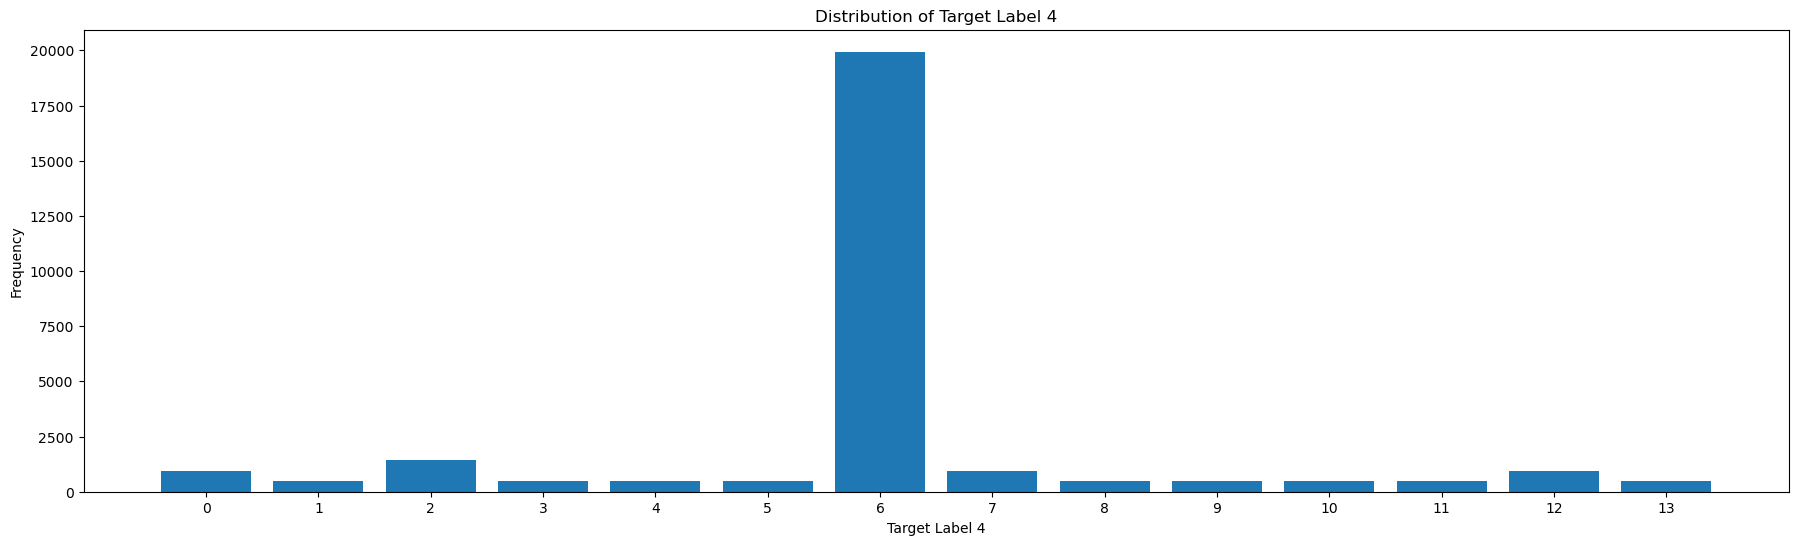

In [55]:
# plot the distribution of train_label4
labels, counts = np.unique(train_label4, return_counts=True)

plt.figure(figsize=(22, 6))
plt.xticks(labels)
plt.bar(labels, counts)
plt.xlabel('Target Label 4')
plt.ylabel('Frequency')
plt.title('Distribution of Target Label 4')
plt.show()

In [56]:
# create an instance of the RandomOverSampler
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# create an instance of the RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# create a pipeline that first applies over-sampling and then under-sampling
sampling_pipeline = Pipeline([
    ('over_sampling', over_sampler),
    ('under_sampling', under_sampler)
])

train_features_label4, train_label4 = sampling_pipeline.fit_resample(train_features_label4, train_label4)

In [57]:
# standardize the features
scaler = RobustScaler()
standardized_train_features_label4 = scaler.fit_transform(train_features_label4)
standardized_valid_features_label4 = scaler.transform(valid_features_label4)
standardized_test_features_label4 = scaler.transform(test_features_label4)

joblib.dump(scaler, './../saved_components/layer10/label_4/scaler.pkl')

['./../saved_components/layer10/label_4/scaler.pkl']

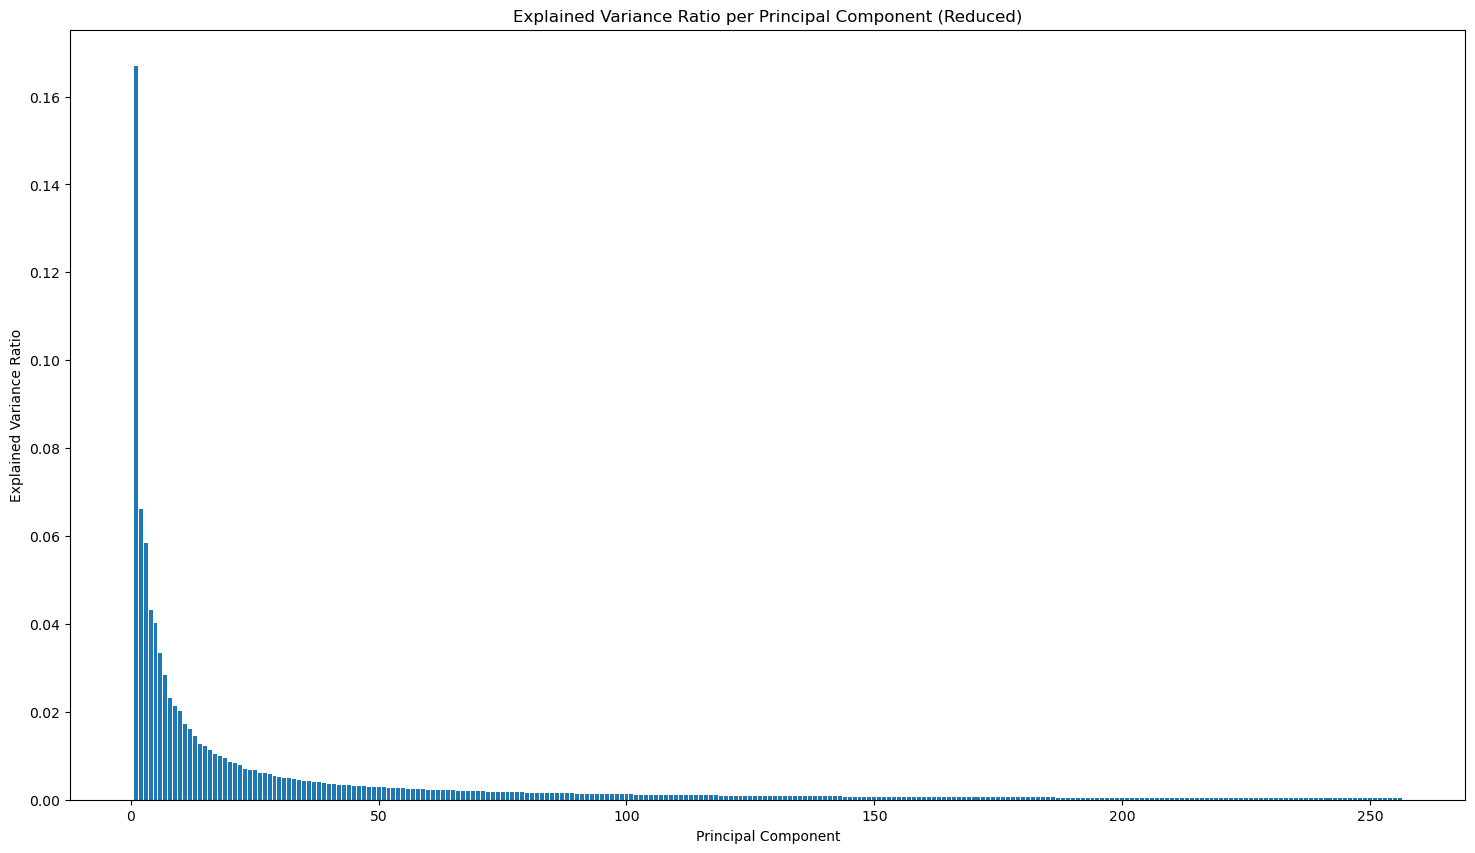

Reduced Train feature matrix shape: (279132, 256)
Reduced valid feature matrix shape: (750, 256)
Reduced test feature matrix shape: (750, 256)


['./../saved_components/layer10/label_4/pca.pkl']

In [58]:
# threshold for variance
variance_threshold = 0.95

# apply PCA with the determined number of components
pca = PCA(n_components=variance_threshold, svd_solver='full')

pca_train_features_label4 = pca.fit_transform(standardized_train_features_label4)
pca_valid_features_label4 = pca.transform(standardized_valid_features_label4)
pca_test_features_label4 = pca.transform(standardized_test_features_label4)

# explained variance ratio after dimensionality reduction
explained_variance_ratio_reduced = pca.explained_variance_ratio_

# plot explained variance ratio
plt.figure(figsize=(18, 10))
plt.bar(range(1, pca_train_features_label4.shape[1] + 1), explained_variance_ratio_reduced)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component (Reduced)')
plt.show()

# get the reduced train feature matrix
print("Reduced Train feature matrix shape: {}".format(pca_train_features_label4.shape))
# get the reduced valid feature matrix
print("Reduced valid feature matrix shape: {}".format(pca_valid_features_label4.shape))
# get the reduced test feature matrix
print("Reduced test feature matrix shape: {}".format(pca_test_features_label4.shape))

joblib.dump(pca, './../saved_components/layer10/label_4/pca.pkl')

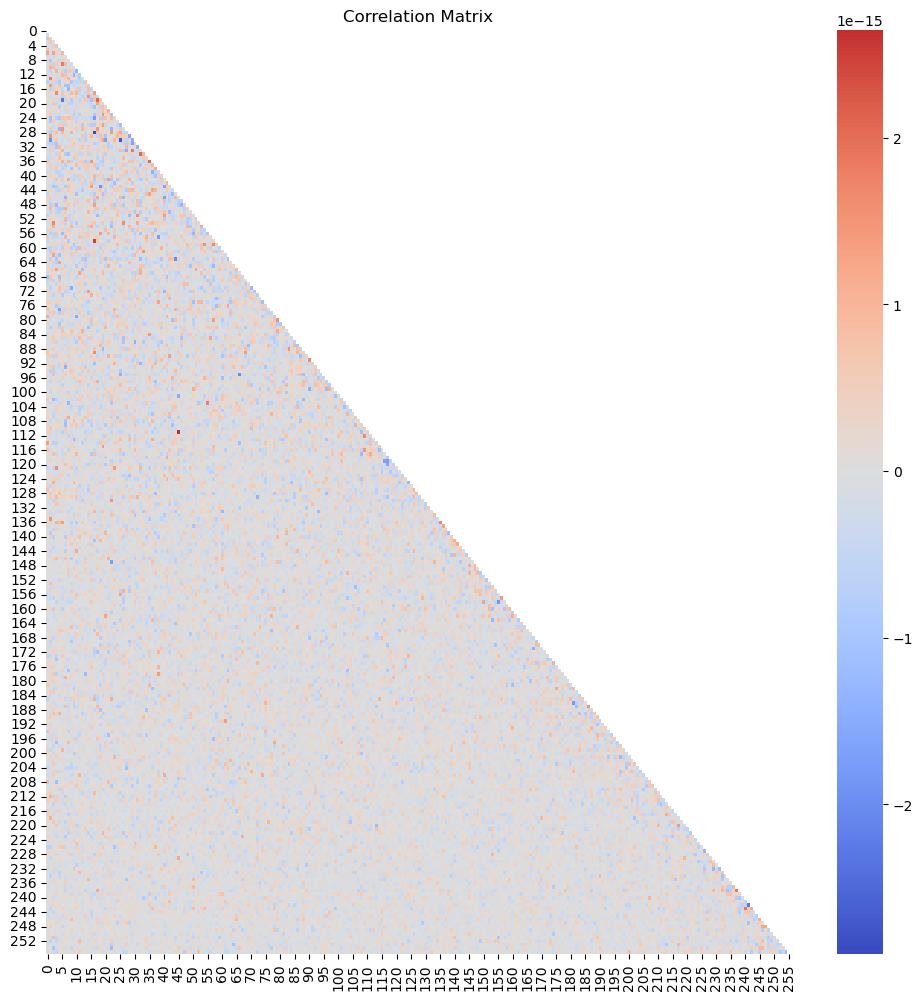

In [59]:
# calculate the correlation matrix
correlation_matrix = pd.DataFrame(pca_train_features_label4).corr()

mask = np.triu(np.ones_like(correlation_matrix))

# create a heatmap of the correlation matrix using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, mask=mask)
plt.title("Correlation Matrix")
plt.show()

In [60]:
# set the threshold for correlation
correlation_threshold = 0.9

highly_correlated = set()

# get highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)

print(highly_correlated)

set()


In [61]:
# remove highly correlated features
pca_train_features_label4 = pd.DataFrame(pca_train_features_label4).drop(columns=highly_correlated)
pca_valid_features_label4 = pd.DataFrame(pca_valid_features_label4).drop(columns=highly_correlated)
pca_test_features_label4 = pd.DataFrame(pca_test_features_label4).drop(columns=highly_correlated)

# get the filtered train feature count
print("Filtered train features: {}".format(pca_train_features_label4.shape))

# get the filtered valid feature count
print("Filtered valid features: {}".format(pca_valid_features_label4.shape))

# get the filtered test feature count
print("Filtered test features: {}".format(pca_test_features_label4.shape))

Filtered train features: (279132, 256)
Filtered valid features: (750, 256)
Filtered test features: (750, 256)


In [62]:
# calculate the correlation matrix between features and train_label4
correlation_with_target = pca_train_features_label4.corrwith(train_label4)

# set the correlation threshold
correlation_threshold = 0.005

# select features that meet the correlation threshold
highly_correlated_features = correlation_with_target[correlation_with_target.abs() > correlation_threshold]

print(highly_correlated_features)

1     -0.043154
2     -0.053300
3      0.008161
5      0.113907
6     -0.031996
         ...   
250    0.042887
251    0.019391
252    0.018499
254    0.026513
255   -0.034432
Length: 220, dtype: float64


In [63]:
# drop the features with low correlated in train data
pca_train_features_label4 = pca_train_features_label4[highly_correlated_features.index]

# drop the features with low correlated in valid data
pca_valid_features_label4 = pca_valid_features_label4[highly_correlated_features.index]

# drop the features with low correlated in test data
pca_test_features_label4 = pca_test_features_label4[highly_correlated_features.index]


# get the filtered train feature count
print("Filtered train features: {}".format(pca_train_features_label4.shape))

# get the filtered valid feature count
print("Filtered valid features: {}".format(pca_valid_features_label4.shape))

# get the filtered test feature count
print("Filtered test features: {}".format(pca_test_features_label4.shape))

Filtered train features: (279132, 220)
Filtered valid features: (750, 220)
Filtered test features: (750, 220)


In [26]:
# parameters for hyperparameter tuning of label 4 with SVM
svm_grid_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','linear']
}


# search across all different combinations, and use all available cores
rs = HalvingGridSearchCV(
    estimator = SVC(),
    param_grid = svm_grid_params,
    factor = 2,
    cv = 3, verbose=2, n_jobs = -1
)
rs_result = rs.fit(pca_train_features_label4, train_label4)

print(f"best score for SVM : {rs_result.best_score_}")
print(f"best hyper parameters for SVM : {rs_result.best_params_}")

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 8722
max_resources_: 279132
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 8722
Fitting 3 folds for each of 50 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 25
n_resources: 17444
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 2
n_candidates: 13
n_resources: 34888
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 3
n_candidates: 7
n_resources: 69776
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 4
n_candidates: 4
n_resources: 139552
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 5
n_candidates: 2
n_resources: 279104
Fitting 3 folds for each of 2 candidates, totalling 6 fits
best score for SVM : 0.999921175770865
best hyper parameters for SVM : {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [64]:
# define the classification model
model = SVC(C=10, gamma=0.01, kernel='rbf')

# get number of features used in PCA
num_features = pca_train_features_label4.shape[1]
print(f"Number of features: {num_features}\n")

# train the model on the training data
model.fit(pca_train_features_label4, train_label4)

# predict on the train data
y_pred_train_label4 = model.predict(pca_train_features_label4)

# calculate metrics for classification evaluation
accuracy = accuracy_score(train_label4, y_pred_train_label4)
precision = precision_score(train_label4, y_pred_train_label4, average='macro', zero_division=1)
recall = recall_score(train_label4, y_pred_train_label4, average='macro')

print(f"Metrics for SVM on train data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

# predict on the validation data
y_pred_valid_label4 = model.predict(pca_valid_features_label4)

# calculate metrics for classification evaluation on validation data
accuracy = accuracy_score(valid_label4, y_pred_valid_label4)
precision = precision_score(valid_label4, y_pred_valid_label4, average='macro', zero_division=1)
recall = recall_score(valid_label4, y_pred_valid_label4, average='macro')

print(f"Metrics for SVM on validation data:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

# predict on the test data
y_pred_test_label4 = model.predict(pca_test_features_label4)

joblib.dump(model, './../saved_components/layer10/label_4/model.pkl')

Number of features: 220

Metrics for SVM on train data:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


Metrics for SVM on validation data:
Accuracy: 0.95
Precision: 1.00
Recall: 0.84




['./../saved_components/layer10/label_4/model.pkl']

# Generate Output CSV

Define method to create the csv file

In [50]:
# define method to create the dataframe and save it as a csv file
def create_csv(ID, pred_label1, pred_label2, pred_label3, pred_label4, destination):
  df = pd.DataFrame()
  
  df.insert(loc=0, column='ID', value=ID)
  df.insert(loc=1, column='label_1', value=pred_label1)
  df.insert(loc=2, column='label_2', value=pred_label2)
  df.insert(loc=3, column='label_3', value=pred_label3)
  df.insert(loc=4, column='label_4', value=pred_label4)

  df.to_csv(destination, index=False)

Create CSV file

In [51]:
destination = 'D:/UOM/Semester_7/3 - CS4622 - Machine Learning/Kaggle/layer 10/results/190495.csv'

# create the csv output file
create_csv(ID, y_pred_test_label1, y_pred_test_label2, y_pred_test_label3, y_pred_test_label4, destination)